In [124]:
import numpy as np
import cv2
import math
from scipy.spatial.distance import cdist, cosine
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt


class ShapeContext(object):

    def __init__(self, nbins_r=5, nbins_theta=12, r_inner=0.1250, r_outer=2.0):
        # number of radius zones
        self.nbins_r = nbins_r
        # number of angles zones
        self.nbins_theta = nbins_theta
        # maximum and minimum radius
        self.r_inner = r_inner
        self.r_outer = r_outer

    def _hungarian(self, cost_matrix):
        """
            Here we are solving task of getting similar points from two paths
            based on their cost matrixes. 
            This algorithm has dificulty O(n^3)
            return total modification cost, indexes of matched points
        """
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        total = cost_matrix[row_ind, col_ind].sum()
        indexes = zip(row_ind.tolist(), col_ind.tolist())
        return total, indexes

    def get_points_from_img(self, image, threshold=50, simpleto=100, radius=2):
        """
            That is not very good algorithm of choosing path points, but it will work for our case.

            Idea of it is just to create grid and choose points that on this grid.
        """
        if len(image.shape) > 2:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        dst = cv2.Canny(image, threshold, threshold * 3, 3)

        py, px = np.gradient(image)
        # px, py gradients maps shape can be smaller then input image shape
        points = [index for index, val in np.ndenumerate(dst)
                  if val == 255 and index[0] < py.shape[0] and index[1] < py.shape[1]]
        h, w = image.shape

        _radius = radius
        while len(points) > simpleto:
            newpoints = points
            xr = range(0, w, _radius)
            yr = range(0, h, _radius)
            for p in points:
                if p[0] not in yr and p[1] not in xr:
                    newpoints.remove(p)
                    if len(points) <= simpleto:
                        T = np.zeros((simpleto, 1))
                        for i, (y, x) in enumerate(points):
                            radians = math.atan2(py[y, x], px[y, x])
                            T[i] = radians + 2 * math.pi * (radians < 0)
                        return points, np.asmatrix(T)
            _radius += 1

        T = np.zeros((simpleto, 1))
        for i, (y, x) in enumerate(points):
            radians = math.atan2(py[y, x], px[y, x])
            T[i] = radians + 2 * math.pi * (radians < 0)

        return points, np.asmatrix(T)

    def _cost(self, hi, hj):
        cost = 0
        for k in range(self.nbins_theta * self.nbins_r):
            if (hi[k] + hj[k]):
                cost += ((hi[k] - hj[k])**2) / (hi[k] + hj[k])

        return cost * 0.5

    def cost_by_paper(self, P, Q, qlength=None):
        p, _ = P.shape
        p2, _ = Q.shape
        d = p2
        if qlength:
            d = qlength
        C = np.zeros((p, p2))
        for i in range(p):
            for j in range(p2):
                C[i, j] = self._cost(Q[j] / d, P[i] / p)

        return C

    def compute(self, points):
        """
          Here we are computing shape context descriptor
        """
        t_points = len(points)
        # getting euclidian distance
        r_array = cdist(points, points)
        # getting two points with maximum distance to norm angle by them
        # this is needed for rotation invariant feature
        am = r_array.argmax()
        max_points = [int(am / t_points), int(am % t_points)]
        # normalizing
        r_array_n = r_array / r_array.mean()
        # create log space
        r_bin_edges = np.logspace(np.log10(self.r_inner), np.log10(self.r_outer), self.nbins_r)
        r_array_q = np.zeros((t_points, t_points), dtype=int)
        # summing occurences in different log space intervals
        # logspace = [0.1250, 0.2500, 0.5000, 1.0000, 2.0000]
        # 0    1.3 -> 1 0 -> 2 0 -> 3 0 -> 4 0 -> 5 1
        # 0.43  0     0 1    0 2    1 3    2 4    3 5
        for m in range(self.nbins_r):
            r_array_q += (r_array_n < r_bin_edges[m])

        fz = r_array_q > 0

        # getting angles in radians
        theta_array = cdist(points, points, lambda u, v: math.atan2((v[1] - u[1]), (v[0] - u[0])))
        norm_angle = theta_array[max_points[0], max_points[1]]
        # making angles matrix rotation invariant
        theta_array = (theta_array - norm_angle * (np.ones((t_points, t_points)) - np.identity(t_points)))
        # removing all very small values because of float operation
        theta_array[np.abs(theta_array) < 1e-7] = 0

        # 2Pi shifted because we need angels in [0,2Pi]
        theta_array_2 = theta_array + 2 * math.pi * (theta_array < 0)
        # Simple Quantization
        theta_array_q = (1 + np.floor(theta_array_2 / (2 * math.pi / self.nbins_theta))).astype(int)

        # building point descriptor based on angle and distance
        nbins = self.nbins_theta * self.nbins_r
        descriptor = np.zeros((t_points, nbins))
        for i in range(t_points):
            sn = np.zeros((self.nbins_r, self.nbins_theta))
            for j in range(t_points):
                if (fz[i, j]):
                    sn[r_array_q[i, j] - 1, theta_array_q[i, j] - 1] += 1
            descriptor[i] = sn.reshape(nbins)

        return descriptor

    def cosine_diff(self, P, Q):
        """
            Fast cosine diff.
        """
        P = P.flatten()
        Q = Q.flatten()
        assert len(P) == len(Q), 'number of descriptors should be the same'
        return cosine(P, Q)

    def diff(self, P, Q, qlength=None):
        """
            More precise but not very speed efficient diff.

            if Q is generalized shape context then it compute shape match.

            if Q is r point representative shape contexts and qlength set to 
            the number of points in Q then it compute fast shape match.

        """
        result = None
        C = self.cost_by_paper(P, Q, qlength)

        result = self._hungarian(C)

        return result

    @classmethod
    def tests(cls):
        # basics tests to see that all algorithm invariants options are working fine
        self = cls()

        def test_move():
            p1 = np.array([
                [0, 100],
                [200, 60],
                [350, 220],
                [370, 100],
                [70, 300],
            ])
            # +30 by x
            p2 = np.array([
                [0, 130],
                [200, 90],
                [350, 250],
                [370, 130],
                [70, 330]
            ])
            c1 = self.compute(p1)
            c2 = self.compute(p2)
            assert (np.abs(c1.flatten() - c2.flatten())
                    ).sum() == 0, "Moving points in 2d space should give same shape context vector"

        def test_scale():
            p1 = np.array([
                [0, 100],
                [200, 60],
                [350, 220],
                [370, 100],
                [70, 300],
            ])
            # 2x scaling
            p2 = np.array([
                [0, 200],
                [400, 120],
                [700, 440],
                [740, 200],
                [149, 600]
            ])
            c1 = self.compute(p1)
            c2 = self.compute(p2)
            assert (np.abs(c1.flatten() - c2.flatten())
                    ).sum() == 0, "Scaling points in 2d space should give same shape context vector"

        def test_rotation():
            p1 = np.array(
                [(144, 196), (220, 216), (330, 208)]
            )
            # 90 degree rotation
            theta = np.radians(90)
            c, s = np.cos(theta), np.sin(theta)
            R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
            p2 = np.dot(p1, R).tolist()

            c1 = self.compute(p1)
            c2 = self.compute(p2)
            assert (np.abs(c1.flatten() - c2.flatten())
                    ).sum() == 0, "Rotating points in 2d space should give same shape context vector"

        test_move()
        test_scale()
        test_rotation()
        print('Tests PASSED')


ShapeContext.tests()

Tests PASSED


In [125]:
def plot(img, img2, rotate=False):
    sc = ShapeContext()
    sampls = 300

    points1,t1 = sc.get_points_from_img(img,simpleto=sampls)
    points2,t2 = sc.get_points_from_img(img2,simpleto=sampls)
    points2 = (np.array(points2)+30).tolist()

    if rotate:
        # https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
        theta = np.radians(90)
        c, s = np.cos(theta), np.sin(theta)
        R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
        points2 = np.dot(np.array(points2), R).tolist()

    P = sc.compute(points1)
    print(P[0])
    x1 = [p[1] for p in points1]
    y1 = [p[0] for p in points1]
    Q = sc.compute(points2)
    x2 = [p[1] for p in points2]
    y2 = [p[0] for p in points2]

    standard_cost,indexes = sc.diff(P,Q)
    
    lines = []
    for p,q in indexes:
        lines.append(((points1[p][1],points1[p][0]), (points2[q][1],points2[q][0])))
    
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    ax = plt.subplot(121)
    plt.gca().invert_yaxis()
    plt.plot(x1,y1,'go', x2,y2, 'ro')
    
    ax = plt.subplot(122)
    plt.gca().invert_yaxis()
    plt.plot(x1,y1,'go',x2,y2,'ro')
    for p1,p2 in lines:   
        plt.gca().invert_yaxis()
        plt.plot((p1[0],p2[0]),(p1[1],p2[1]), 'k-')
    plt.show()
    print("Cosine diff:", cosine(P.flatten(), Q.flatten()))
    print("Standard diff:", standard_cost)

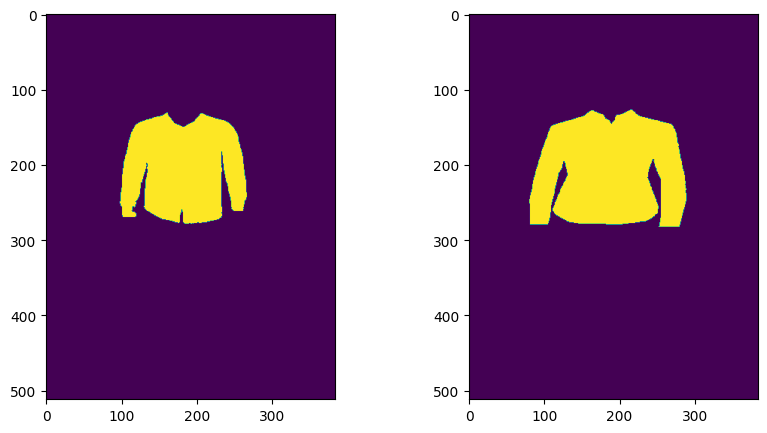

[23. 65. 61. 73.  8.  0.  0.  0.  0.  0.  0.  0.  8. 19.  0.  1. 16.  0.
  0.  0.  0.  0.  0.  3.  0.  0.  0.  2.  5.  0.  0.  0.  0.  0.  0.  4.
  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  2.  1.  0.  0.  3.  0.  0.
  0.  0.  0.  0.  0.  2.]


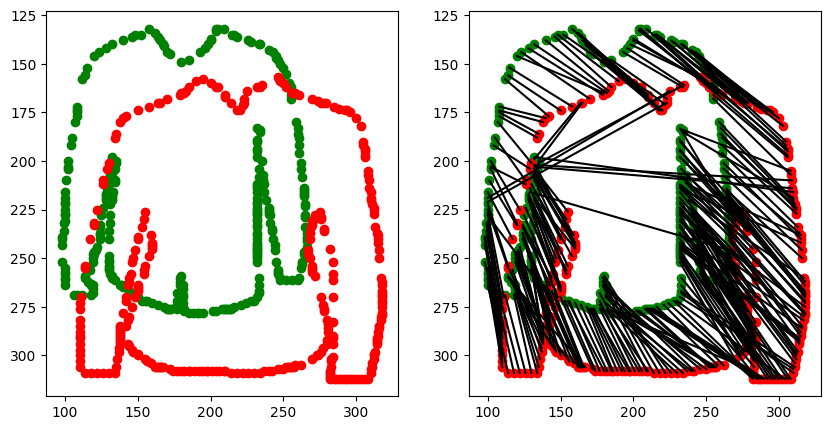

Cosine diff: 0.45102861962379703
Standard diff: 39.043281687538155


In [126]:
img = cv2.imread('data/osim.png', 0)
img2 = cv2.imread('data/clothes_mask.png', 0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img)
axes[1].imshow(img2)
plt.show()
plot(img, img2)


## Role as main

[23. 65. 61. 73.  8.  0.  0.  0.  0.  0.  0.  0.  8. 19.  0.  1. 16.  0.
  0.  0.  0.  0.  0.  3.  0.  0.  0.  2.  5.  0.  0.  0.  0.  0.  0.  4.
  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  2.  1.  0.  0.  3.  0.  0.
  0.  0.  0.  0.  0.  2.]


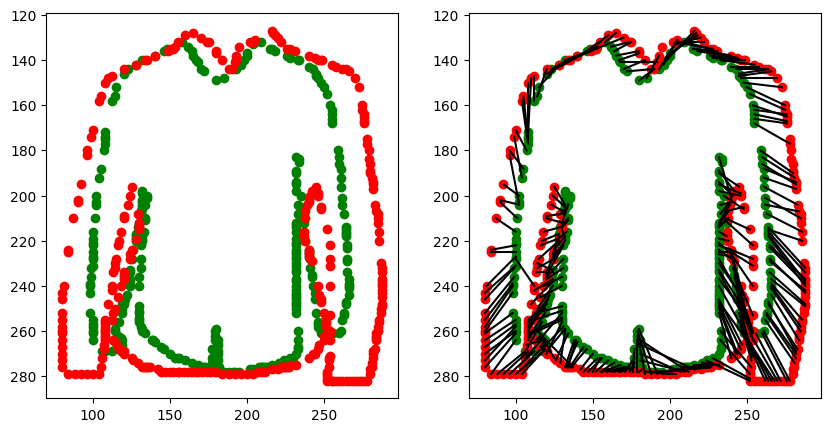

Cosine diff: 0.45102861962379703
Standard diff: 39.043281687538155


In [128]:
target_model = cv2.imread('./data/osim.jpg')
target_mask = cv2.imread('./data/osim.png')
clothes = cv2.imread('./data/align_shirt.png')
target_mask = cv2.GaussianBlur(target_mask, (5, 5), 0)

clothes_gray = cv2.cvtColor(clothes, cv2.COLOR_BGR2GRAY)
clothes_mask = cv2.threshold(clothes_gray, 0, 255, cv2.THRESH_BINARY)[1]
clothes_mask = cv2.GaussianBlur(clothes_mask, (5, 5), 0)

sc = ShapeContext()
sampls = 300
rotate = False

points1,t1 = sc.get_points_from_img(img,simpleto=sampls)
points2,t2 = sc.get_points_from_img(img2,simpleto=sampls)
points2 = (np.array(points2)).tolist()

if rotate:
    # https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
    theta = np.radians(90)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
    points2 = np.dot(np.array(points2), R).tolist()

P = sc.compute(points1)
print(P[0])
x1 = [p[1] for p in points1]
y1 = [p[0] for p in points1]
Q = sc.compute(points2)
x2 = [p[1] for p in points2]
y2 = [p[0] for p in points2]

standard_cost,indexes = sc.diff(P,Q)

lines = []
for p,q in indexes:
    distance = math.sqrt(((points1[p][0]-points2[q][0])**2)+((points1[p][1]-points2[q][1])**2))
    if distance < standard_cost:
        lines.append(((points1[p][1],points1[p][0]), (points2[q][1],points2[q][0])))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = plt.subplot(121)
plt.gca().invert_yaxis()
plt.plot(x1,y1,'go', x2,y2, 'ro')

ax = plt.subplot(122)
plt.gca().invert_yaxis()
plt.plot(x1,y1,'go',x2,y2,'ro')
for p1,p2 in lines:   
    plt.gca().invert_yaxis()
    plt.plot((p1[0],p2[0]),(p1[1],p2[1]), 'k-')
plt.show()
print("Cosine diff:", cosine(P.flatten(), Q.flatten()))
print("Standard diff:", standard_cost)

In [129]:
points1 = np.array(points1, dtype=np.int32)
points2 = np.array(points2, dtype=np.int32)

for i in range(points1.shape[0]):
    print(points1[i], points2[i])

[132 158] [127 216]
[132 204] [128 165]
[132 205] [128 217]
[132 209] [129 160]
[133 204] [129 218]
[134 162] [130 170]
[135 148] [130 220]
[135 152] [131 205]
[135 215] [132 155]
[135 216] [132 174]
[136 146] [132 175]
[136 164] [132 202]
[136 218] [132 204]
[137 200] [132 222]
[138 140] [134 153]
[138 165] [134 195]
[138 200] [135 150]
[138 226] [135 152]
[139 228] [135 226]
[140 132] [135 228]
[140 167] [136 149]
[140 198] [136 180]
[140 233] [136 231]
[140 234] [137 180]
[141 168] [138 140]
[142 128] [138 193]
[142 196] [138 240]
[143 240] [139 244]
[144 123] [140 134]
[144 170] [140 135]
[144 193] [140 184]
[144 243] [140 193]
[145 172] [140 246]
[146 120] [140 248]
[146 245] [140 249]
[147 245] [141 192]
[148 185] [142 128]
[148 246] [142 255]
[149 180] [143 258]
[150 248] [144 120]
[152 115] [144 188]
[152 250] [144 190]
[155 252] [144 262]
[156 114] [144 264]
[158 112] [145 266]
[160 254] [147 112]
[162 255] [148 110]
[164 255] [148 270]
[166 255] [150 108]
[168 255] [152 273]


In [130]:
def WarpImage_TPS(source, target, img):
    tps = cv2.createThinPlateSplineShapeTransformer()
        
    source=source.reshape(-1, len(source),2)
    target=target.reshape(-1, len(target),2)
    
    matches=list()
    
    for i in range(0,len(source[0])):
        matches.append(cv2.DMatch(i,i,0))
    
    matches = sorted(matches, key=lambda x: x.distance)

    tps.estimateTransformation(target, source, matches)
    new_img = tps.warpImage(img)
    
    return new_img, matches

In [133]:
img2_aligned, matches = WarpImage_TPS(points1, points2, clothes)

In [134]:
cv2.imshow('Aligned Image', img2_aligned)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import random

def visualize_matches(img1, keypoints1, img2, keypoints2, matches):
    # Create a new image to display the matches
    height = max(img1.shape[0], img2.shape[0])
    width = img1.shape[1] + img2.shape[1]
    img_matches = np.zeros((height, width, 3), dtype=np.uint8)

    # Concatenate the two input images horizontally
    img_matches[:img1.shape[0], :img1.shape[1]] = img1
    img_matches[:img2.shape[0], img1.shape[1]:] = img2

    # Draw lines between the matching keypoints
    for match in matches:
        # Get the keypoints indices for the current match
        idx1 = match.queryIdx
        idx2 = match.trainIdx
        
        # Get the coordinates of the keypoints
        pt1 = tuple(map(int, keypoints1[idx1]))
        pt2 = tuple(map(int, keypoints2[idx2]))

        # Draw a line between the keypoints
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)
        cv2.line(img_matches, pt1, (pt2[0] + img1.shape[1], pt2[1]), (b, g, r), 1)

    # Display the image with the matching keypoints
    cv2.imshow('Matches', img_matches)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
visualize_matches(target_mask, points1, clothes, points2, matches)